In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation, writers, PillowWriter
from copy import copy
from datetime import timedelta

In [6]:
datadir = '/data/oceanparcels/output_data/data_Delphine/' #Reint/'
regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean',
           'NPSG': 'North Pacific Subtropical Gyre'}

In [5]:
r_pl_clist = ['#7a0177','#c51b8a','#f768a1', '#fbb4b9']
r_pl_cmap = plt.get_cmap('RdPu_r')

In [6]:
region = 'SO'
mortality = 0.39              # [d-1]
runtime = 458 #822#853                 # [days]
dt = 60                       # [seconds]
outputdt = 12                  # [hours]
biofouling = 'MEDUSA'
mixing = 'markov_0_'+biofouling #KPP_ceiling_tides_
diss = 0.006
rho_bf = 1388
rho_fr = 1800
sizebinedges = [1e-3, 1e-4, 1e-5]
res ='1x1'
proc = 'bfnoadv'
season = 'Oct' #'SON'
season_string = {'Jan':'January - July', 'MAM':'March - September', 'JJA':'June - December', 'SON':'September - March','DJF':'December - June'}

In [8]:
filename = datadir+'regional_'+region+'_'+proc+'_'+season+'_2003_'+res+'res_'+mixing+'_'+str(rho_bf)+'rhobf_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc'
print(filename)
ds = xr.open_dataset(filename)

/data/oceanparcels/output_data/data_Delphine/regional_SO_bfnoadv_Oct_2003_1x1res_markov_0_MEDUSA_1388rhobf_458days_60dtsecs_12hrsoutdt.nc


In [9]:
number_of_trajectories_to_plot = 250
n_plt = number_of_trajectories_to_plot
f_plt = int(np.round(len(ds['traj'])/n_plt))
print('plotting '+str(n_plt)+' of '+str(len(ds['traj']))+' trajectories')
print('plotting every '+str(f_plt)+' particles')

plotting 250 of 10000 trajectories
plotting every 40 particles


#### Calculating mean MLD

In [21]:
mld = np.mean(ds['mld'][:,1:],axis=0)
mld = np.concatenate(([mld[0]],mld))
ds['days'] = (['traj','obs'],(ds['time'][:,:].T.values-ds['time'][:,0].T.values).T.astype(np.float64)/86400/1e9)

### Plot trajectories
By looking at the individual trajectories we can discover general patterns

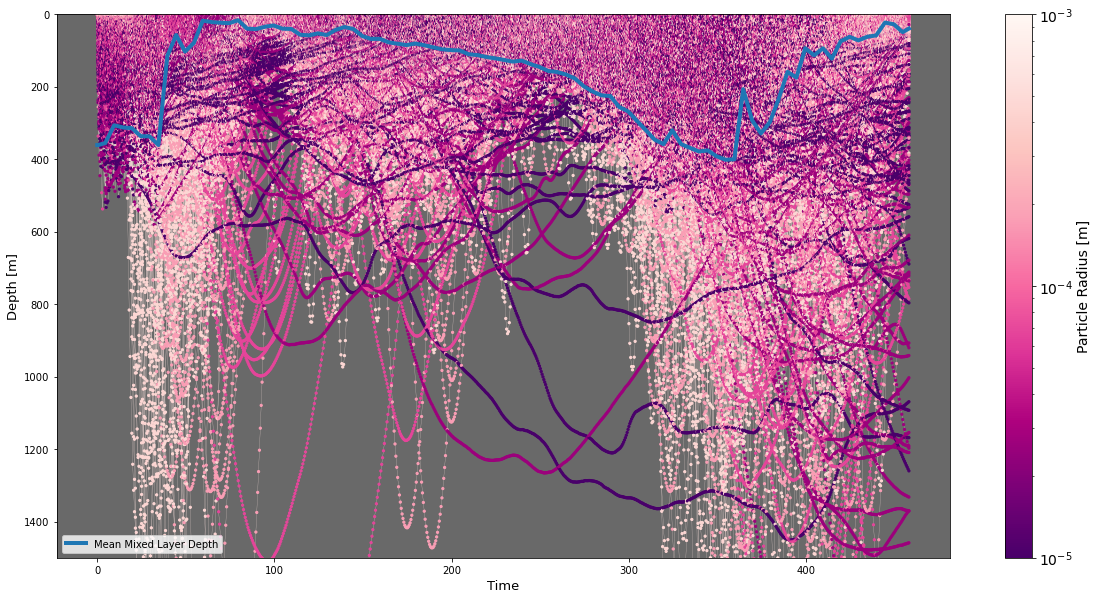

In [22]:
fig = plt.figure(figsize=(20,10))
ax1=plt.axes()

sc = ax1.scatter(ds['days'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=np.tile(ds['r_pl'].T[::f_plt],[len(ds['obs']),1]),cmap=r_pl_cmap,norm=colors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax1.plot(ds['days'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.plot(ds['days'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
# ax1.set_title('Sinking trajectories with wind mixing and '+death+' biofilm dynamics', fontsize=16)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
ax1.set_facecolor('dimgray')
ax1.set_ylim(1500,0)

cb = fig.colorbar(sc, ax=ax1)
cb.set_label('Particle Radius [m]', fontsize=14)
cb.ax.tick_params(labelsize=14)
ax1.legend(loc = 'lower left')
plt.show()

The depth timeseries of the particles shows that they follow a near parabolical trajectory where the timespan of an oscillation depends on the particle size. By looking at the dominant velocities and biofilm dynamics, we can discover that this oscillation is dominated by a linear loss of biofilm due to respiration among other processes.

In [23]:
radii = np.unique(ds['r_pl'])

In [24]:
split_ds = list(ds.groupby('r_pl'))

In [25]:
rad_cmap = copy(plt.get_cmap('RdPu_r', len(split_ds)))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

rad_cmap = truncate_colormap(rad_cmap, 0.0, 0.65)
r_pl_list = rad_cmap(np.linspace(0.,1.,len(split_ds)))

In [26]:
#%matplotlib notebook
#%matplotlib ipympl
#%matplotlib widget
%matplotlib inline

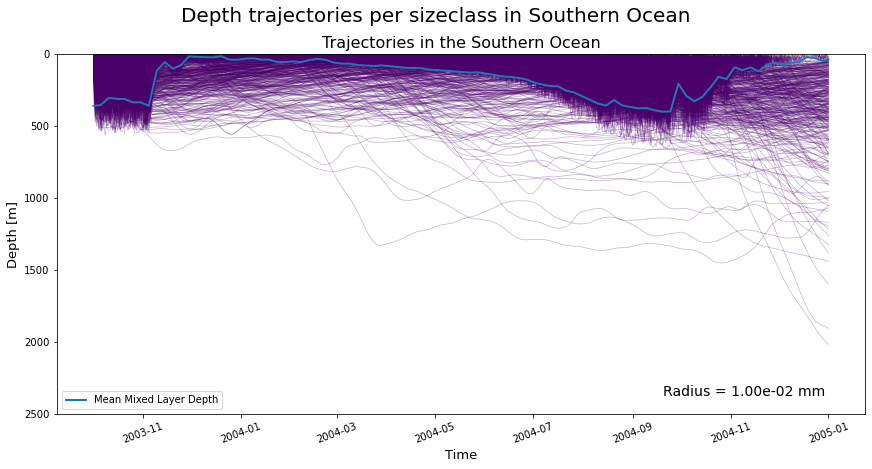

In [27]:
fig = plt.figure(figsize=(12,6), constrained_layout=True)
fig.suptitle('Depth trajectories per sizeclass in '+regions[region], fontsize=20, y=1.06)
ax0 = plt.axes()

ln = ax0.plot(split_ds[0][1]['time'].T[:,:], split_ds[0][1]['z'].T[:,:], color=r_pl_list[0],linewidth=0.7, alpha=0.3,zorder=1)
ax0.plot(ds['time'][0,:], mld, linewidth=2, label='Mean Mixed Layer Depth')
ax0.set_title('Trajectories in the '+regions[region], fontsize=16)
rad = ax0.text(0.75, 0.05,'Radius = '+"{:.2e} mm".format(radii[0]*1000), fontsize=14, transform=ax0.transAxes)
ax0.set_ylabel('Depth [m]', fontsize=13)
ax0.set_xlabel('Time', fontsize=13)
# ax0.set_facecolor('dimgray')
ax0.set_ylim(2500,0)
ax0.legend(loc = 'lower left')
ax0.tick_params(axis='x', rotation=20)

def animate(i):
    for lnum,line in enumerate(ln):
        line.set_ydata(split_ds[i][1]['z'].T[:,lnum]) # set data for each line separately. 
        line.set_color(r_pl_list[i])
    rad.set_text('Radius = '+"{:.2e} mm".format(radii[i]*1000))
    return ln, rad,
    
anim = FuncAnimation(fig, animate, frames = len(radii), interval=1000)

# writergif = PillowWriter(fps=3, codec="libx264")
# anim.save(region+'_oscillations.gif', writer=writergif)

plt.show()

## Characterisation

In [4]:
osc_stats_EqPac = np.load('/data/oceanparcels/output_data/data_Delphine/EqPac_oscillation_stats_rhobf1170.npy')
osc_stats_NPSG = np.load('/data/oceanparcels/output_data/data_Delphine/NPSG_oscillation_stats_rhobf1170.npy')
osc_stats_SO = np.load('/data/oceanparcels/output_data/data_Delphine/SO_oscillation_stats_rhobf1170.npy')

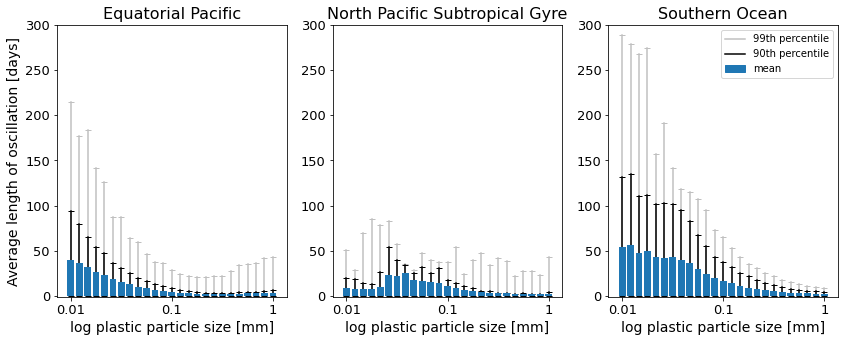

In [7]:
fig = plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1, 3)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

ax0.set_title(regions['EqPac'], fontsize=16)
ax0.plot([np.linspace(0,24,25),np.linspace(0,24,25)],np.array([np.zeros(25),osc_stats_EqPac[:,6]]),color='silver',marker='_',zorder=0)
ax0.plot([np.linspace(0,24,25),np.linspace(0,24,25)],np.array([np.zeros(25),osc_stats_EqPac[:,5]]),color='k',marker='_',zorder=0)
ax0.bar(np.linspace(0,24,25),osc_stats_EqPac[:,0],zorder=1)
ax0.set_ylim(-1,300)
ax0.set_xlabel('log plastic particle size [mm]', fontsize=14)
ax0.set_ylabel('Average length of oscillation [days]', fontsize=14)
ax0.set_xticks([0,12,24])
ax0.set_xticklabels(['0.01', '0.1', '1'], fontsize=13)
ax0.tick_params(axis='y', labelsize=13)

ax1.set_title(regions['NPSG'], fontsize=16)
ax1.plot([np.linspace(0,24,25),np.linspace(0,24,25)],np.array([np.zeros(25),osc_stats_NPSG[:,6]]),color='silver',marker='_',zorder=0)
ax1.plot([np.linspace(0,24,25),np.linspace(0,24,25)],np.array([np.zeros(25),osc_stats_NPSG[:,5]]),color='k',marker='_',zorder=0)
ax1.bar(np.linspace(0,24,25),osc_stats_NPSG[:,0],zorder=1)
ax1.set_ylim(-1,300)
ax1.set_xlabel('log plastic particle size [mm]', fontsize=14)
ax1.set_xticks([0,12,24])
ax1.set_xticklabels(['0.01', '0.1', '1'], fontsize=13)
ax1.tick_params(axis='y', labelsize=13)

ax2.set_title(regions['SO'], fontsize=16)
ax2.plot([np.linspace(0,24,25),np.linspace(0,24,25)],np.array([np.zeros(25),osc_stats_SO[:,6]]),color='silver',marker='_',zorder=0)
ax2.plot([np.linspace(0,24,25),np.linspace(0,24,25)],np.array([np.zeros(25),osc_stats_SO[:,5]]),color='k',marker='_',zorder=0)
ax2.bar(np.linspace(0,24,25),osc_stats_SO[:,0],zorder=1)
ax2.set_ylim(-1,300)
ax2.set_xlabel('log plastic particle size [mm]', fontsize=14)
ax2.set_xticks([0,12,24])
ax2.set_xticklabels(['0.01', '0.1', '1'], fontsize=13)
ax2.tick_params(axis='y', labelsize=13)

custom_lines = [Line2D([0], [0], color='silver', lw=1.5),
                Line2D([0], [0], color='k', lw=1.5),
                Patch(color='tab:blue')]

ax2.legend(custom_lines, ["99th percentile", "90th percentile", "mean"], loc='upper right')